In [2]:
import pandas as pd
import numpy as np
import sparkge as sg
from sparkge import evolution as evo
from sparkge.evolution import length_of
from sparkge.providers.fitness import *
import warnings
%matplotlib inline
res = np.seterr(divide='ignore', invalid='ignore') #be careful
warnings.filterwarnings("ignore")
#set recusiion limit sparge.configure()

This notebook describes basic useage of sparkge. See the concepts notebook for a better understanding of the patterns used

# Grammar

In [3]:
from sparkge.symbols import *

def squared(x): return np.power(x,2)
def cubed (x): return np.power(x,3)

@terminal
def var():
    return ["X"]
    #return ["X", "A", "B", "C"]

@terminal
def param():
    #return ["X"]
    return [ "A", "B"]

@terminal(is_constant=True)
def const():return [ 2,3,4,5]#, np.pi

@operator()
def uop(): return [np.exp, np.log]#np.sin, np.cos , np.log, np.sin,

@operator()
def op(): return [add, sub, mul, truediv]#truediv

@operator()
def power(): return [np.power]

def expr(genome=None, args = []):  
    return as_expression(genome, [ op(expr,expr), power(expr,param) ,var, param])
    #return as_expression(genome,  [op(expr,expr),op(expr,expr),  var])

# Sample Expressions

In [4]:
power_sample = np.array([1,0,2])
power_law_sample = np.array([0,2,3,1, 1, 1,2])
#sample using a random genome - re-run cell to see other instances
f= expr(evo.chain(l=power_law_sample,max_wraps=2))#np.array([0,0,3,3])
print(f(X=3,A=4,B=6,C=5))
from sparkge.symbols import _repr_
print(_repr_(f))
S= display(f)
S

486
(B*(X**A))


   A
B⋅X 

## Get some sample data

In [9]:
SAMPLE = pd.read_csv("./sample_data/power_law_data").set_index("L")
SAMPLE

,M1
L,
125,34.378366
125,34.414432
125,34.234352
125,34.135606
125,34.304450
125,34.155411
125,34.153974
125,34.249601
125,33.969251


# Fit the data to sample expression

B*X**A
Est params [ 0.97889322  0.30432094  1.        ]
GoF 0.207326400529


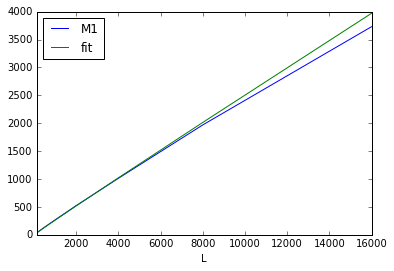

In [6]:
print(display(f))    
_f = accepting_ordered_params(f) #see comments in fnuction accepting_ordered_params
est = curve_fit(_f, SAMPLE, estimate=[[0.1,2,1,]], display=True)
print("Est params", est[0])
print("GoF", goodness_of_fit(_f,SAMPLE, est))

when fitting functions with scipy the convention is to pass the variables parameters in an ordered list f(X, params). To respect that we try to unravel our strict function of f(X=,A=,B=) into something that takes an ordered list. It is important of course to make sure that we map the right ordinal to the right key

# Strategy

In [7]:
s = evo.strategy(pop_size=100, genome_size=100, srate=0.52, mrate=0.01)

# Evolve a test function

In [8]:
lengths, fitnesses, genes = s.init()
for generation in range(1000): 
    fitnesses = sg.symbols._evaluate(genes,expr)#default test function
    meta = np.stack([length_of(genes),fitnesses],axis=1)
    genes = s.select_and_mutate(meta,genes)
    sg.store.update(meta,genes)

# Curve fitting data


In [ ]:
lengths, fitnesses, genes = s.init()
for generation in range(1000):   
    fitnesses = sg.symbols._evaluate_against_data(genes,expr,SAMPLE,p0=[[0.1, 2, 1, 1]]) 
    meta = np.stack([length_of(genes),fitnesses],axis=1)
    sg.store.update(meta,genes)
    genes = s.select_and_mutate(meta,genes)

# Spark

This strategy focuses on the situation where the fitness eval is expensive. Evolution happens centrally and symbols are evaluated in parallel.

We broadcast the data that is used for ftting so that workers have it in memory to process their batches

In [ ]:
#its almost the same except we wrap the call - we broadcast the data so it is shared for everyone in memory
def par_eval(pop):
    with sparkge_context() as sc:
        DATA = sc.sc.broadcast("data", SAMPLE)
        f = lambda genes : sg.symbols._evaluate_against_data(genes,expr,DATA,p0=[[0.1, 2, 1, 1]]) 
        return sc.apply_function(pop, f)

lengths, fitnesses, genes = s.init()
for generation in range(100):   
    fitnesses = par_eval(genes,expr) 
    meta = np.stack([length_of(genes),fitnesses],axis=1)
    store.update(meta,genes)
    genes = s.select_and_mutate(meta,genes)